In [11]:
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [12]:
from spellchecker import SpellChecker


In [13]:
spell = SpellChecker()

In [14]:
filename = "elan_dataset_merged.txt"

In [15]:
output_filename = "elan_cleaned_merged.txt"

In [16]:
def get_token(token):
    
    if token[:8] == "FBUOY:DS":
        split = token.split(':')
        if len(split) > 2:
            token = token.split(':')[2]
    if token[:6] == "FBUOY:":
        split = token.split(':')
        if len(split) > 1:
            token = token.split(':')[1]
    if token[:6] == "FUBOY:":
        split = token.split(':')
        if len(split) > 1:
            token = token.split(':')[1]
    if token[:6] == "FBOUY:":
        split = token.split(':')
        if len(split) > 1:
            token = token.split(':')[1]
    if token[:6] == "GICA):":
        split = token.split(':')
        if len(split) > 1:
            token = token.split(':')[1]
    if token[:6] == "TBUOY:":
        split = token.split(':')
        if len(split) > 1:
            token = token.split(':')[1]
    elif token[:3] == "FS:":
        token = token[3:]
    elif token[:3] == "FB:":
        token = token[3:]
    elif token[:2] == "DS":
        split = token.split(':')
        if len(split) > 1:
            token = token.split(':')[1]
    elif token[:2] == "G(":
        split = token.split(':')
        if len(split) > 1:
            token = token.split(':')[1]
    elif token[:3] == "CA:":
        split = token.split(':')
        if len(split) > 1:
            token = token.split(':')[1]
    elif token[:3] == "GA:":
        split = token.split(':')
        if len(split) > 1:
            token = token.split(':')[1]
    elif token[:2] == "G:":
        split = token.split(':')
        if len(split) > 1:
            token = token.split(':')[1]
    elif token[:2] == "M:":
        split = token.split(':')
        if len(split) > 1:
            token = token.split(':')[1]
    elif token[:2] == "M:":
        split = token.split(':')
        if len(split) > 1:
            token = token.split(':')[1]
    elif token[:7] == "FINISH.":
        token = "FINISH"

    index = token.find("-2H")
    if index != -1:
        token = token[:index]
    index = token.find("-1H")
    if index != -1:
        token = token[:index]
    index = token.find("2-H")
    if index != -1:
        token = token[:index]
    index = token.find("1-H")
    if index != -1:
        token = token[:index]

    index = token.find("(")
    if index != -1:
        token = token[:index]
        
    return token

In [17]:
def clean_sentence(sentence):
    
    sentence = sentence.replace("'s", " is")
    sentence = sentence.replace("n't", " not")
    sentence = sentence.replace("'d", " had")
    sentence = sentence.replace("'ll", " will")
    sentence = sentence.replace("'m", " am")
    sentence = sentence.replace("'ve", " have")
    sentence = sentence.replace("'re", " are")
    sentence = sentence.replace("ahh", "")
    sentence = sentence.replace("umm", "")
    sentence = sentence.replace("?", " ?")

    cleaned_sentence = ""
    
    for char in sentence:
        if char.isalpha() or char == "'" or char == "?":
            cleaned_sentence += char
        else:
            cleaned_sentence += " "
    
    cleaned_sentence = cleaned_sentence.lower()
    cleaned_sentence = re.sub(' +', ' ', cleaned_sentence)
    
    return cleaned_sentence.strip()

def should_skip_token(token):
    if token[:3] == "PT:":
        return True
    if token[:5] == "LOOK(":
        return True
    if token[:7] == "PTBUOY:":
        return True
        
    return False
    
def clean_tokens(token_sequence):
    
    token_sequence = token_sequence.replace("FALSE-START", "")
    token_sequence = token_sequence.replace("FALSE START", "")
    token_sequence = token_sequence.replace("?", " ?")
    tokens = token_sequence.strip().split(" ")
    
    
    cleaned_tokens = []
        
    for token in tokens:
        if token[:3] == "PT:":
            continue
        if token[:5] == "LOOK(":
            continue
        if token[:7] == "PTBUOY:":
            continue
        
        token = get_token(token)
        
        if token in ["WELL", "", "AHH", "UMM", "FSL", "PTBUOY", "HMM", "ERR", "PHOOEY", "INDETERMINATE", "INDECIPHERABLE"]:
            continue

        if token[-1].isdigit():
            token = token[:-1]

        if len(token) < 2:
            continue
                        
        cleaned_tokens.append(token)
        
    unduped_tokens = []
    
    for i in range(0, len(cleaned_tokens)):
        if (i == 0 or cleaned_tokens[i] != cleaned_tokens[i - 1]) and (i < 2 or cleaned_tokens[i] != cleaned_tokens[i - 2]):
            unduped_tokens.append(cleaned_tokens[i].replace("-", " "))
        
    return (" ".join(unduped_tokens)).upper()

def spell_check(sequence, upper):
    sequence = sequence.split(" ")
    output = []
    for word in sequence:
        if upper:
            if spell.correction(word):
                output.append(spell.correction(word).upper())
            else:
                output.append(word)
        else:
            if spell.correction(word):
                output.append(spell.correction(word))
            else:
                output.append(word)
    return " ".join(output)

def create_output_file(input_filename, output_filename):
    input_file = open(input_filename, "r")
    output_file = open(output_filename, "w+")
    lines = input_file.readlines()
    
    cleaned_lines = []
        
    for line in lines:
        split = line.split("\t")
        
        sentence = clean_sentence(clean_sentence(split[0]))
        if len(sentence) == 0:
            continue
        sentence = spell_check(sentence, False)
        
        tokens = clean_tokens(clean_tokens(split[1]))
        if len(tokens) == 0:
            continue
        tokens = spell_check(tokens, True)
        
        if (len(sentence) == 0 or len(tokens) == 0) or sentence.count(" ") > 25 or tokens.count(" ") > 25:
            continue
        
        cleaned_lines.append(f'{clean_sentence(split[0])}\t{clean_tokens(split[1])}\n')
        
    cleaned_lines.sort(key= lambda line: (line.split("\t")[0].count(" ")))
    
    text = ""
    
    for cleaned_line in cleaned_lines:
        text += cleaned_line
        
    output_file.write(text)
    output_file.close()
    input_file.close()
    
    return cleaned_lines

In [18]:
sentences = create_output_file(filename, output_filename)

In [9]:
# def plot_hist(sentences, index, bins, title, ylabel, xlabel):
#     sentence_lengths = []

#     for line in sentences:
#         sentence = line.split("\t")
#         count = sentence[index].count(" ")
#         sentence_lengths.append(count + 1)
    
#     plt.figure(figsize=(14,7)) # Make it 14x7 inch
#     plt.style.use('seaborn-whitegrid') # nice and clean grid

#     n, bins, patches = plt.hist(sentence_lengths, bins=bins, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)

#     n = n.astype('int') # it MUST be integer

#     # Good old loop. Choose colormap of your taste
#     for i in range(len(patches)):
#         patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))


#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     plt.title(title)
#     plt.show()

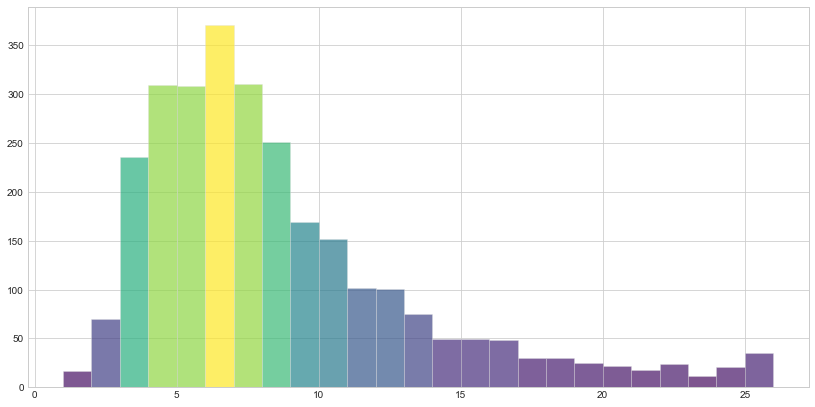

In [10]:
# plot_hist(sentences, 0, 25, "", "", "")